# How To Ensemble OOF
In this notebook, we learn how to use `forward selection` to ensemble OOF. First build lots of models using the same KFolds (i.e. use same `seed`). Next save all the oof files as `oof_XX.csv` and submission files as `sub_XX.csv` where the oof and submission share the same `XX` number. Then save them in a Kaggle dataset and run the code below.

The ensemble begins with the model of highest oof AUC. Next each other model is added one by one to see which additional model increases ensemble AUC the most. The best additional model is kept and the process is repeated until the ensemble AUC doesn't increase.

# Read OOF Files
When i get more time, I will compete this table to describe all 39 models in this notebook. For now here are the ones that get selected:

| k | CV | LB | read size | crop size | effNet | ext data | upsample | misc | name |
| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- |
| 1 | 0.910 | 0.950 | 384 | 384 | B6 | 2018 | no |  | oof_100 |
| 3 | 0.916 | 0.946 | 384 | 384 | B345 | no | no |  | oof_108 |
| 8 | 0.935 | 0.949 | 768 | 512 | B7 | 2018 | 1,1,1,1 |  | oof_113 |
| 10 | 0.920 | 0.941 | 512 | 384 | B5 | 2019 2018 | 10,0,0,0 |  | oof_117 |
| 12 | 0.935 | 0.937 | 768 | 512 | B6 | 2019 2018 | 3,3,0,0 |  | oof_120 |
| 21 | 0.933 | 0.950 | 1024 | 512 | B6 | 2018 | 2,2,2,2 |  | oof_30 |
| 26 | 0.927 | 0.942 | 768 | 384 | B4 | 2018 | no |  | oof_385 |
| 37 | 0.936 | 0.956 | 512 | 384 | B5 | 2018 | 1,1,1,1 |  | oof_67 |


In [28]:
import pandas as pd, numpy as np, os
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

In [29]:
PATH = 'sub/'
FILES = os.listdir(PATH)

OOF = np.sort( [f for f in FILES if 'oof' in f] )
OOF_CSV = [pd.read_csv(PATH+k) for k in OOF]

print('We have %i oof files...'%len(OOF))
print(); print(OOF)

We have 8 oof files...

['eca_nfnetl0_oof_01.csv' 'eff_b0_ns_oof_06.csv' 'eff_b0_oof_05.csv'
 'eff_b3_ns_oof_07.csv' 'eff_b3_ns_w15_oof_02.csv' 'eff_v2_s_oof_03.csv'
 'ensemble_oof.csv' 'oof_df.csv']


In [30]:
x = np.zeros(( len(OOF_CSV[0]),len(OOF) ))
for k in range(len(OOF)):
    x[:,k] = OOF_CSV[k].preds.values
    
TRUE = OOF_CSV[0].target.values

In [31]:
all = []
for k in range(x.shape[1]):
    auc = roc_auc_score(OOF_CSV[0].target,x[:,k])
    all.append(auc)
    print('Model %i has OOF AUC = %.4f'%(k,auc))
    
m = [np.argmax(all)]; w = []

Model 0 has OOF AUC = 0.8745
Model 1 has OOF AUC = 0.8745
Model 2 has OOF AUC = 0.8715
Model 3 has OOF AUC = 0.8774
Model 4 has OOF AUC = 0.8772
Model 5 has OOF AUC = 0.8670
Model 6 has OOF AUC = 0.8745
Model 7 has OOF AUC = 0.8734


# Build OOF Ensemble. Maximize CV Score

In [32]:
old = np.max(all); 

RES = 200; 
PATIENCE = 10; 
TOL = 0.0003
DUPLICATES = False

print('Ensemble AUC = %.4f by beginning with model %i'%(old,m[0]))
print()

for kk in range(len(OOF)):
    
    # BUILD CURRENT ENSEMBLE
    md = x[:,m[0]]
    for i,k in enumerate(m[1:]):
        md = w[i]*x[:,k] + (1-w[i])*md
        
    # FIND MODEL TO ADD
    mx = 0; mx_k = 0; mx_w = 0
    print('Searching for best model to add... ')
    
    # TRY ADDING EACH MODEL
    for k in range(x.shape[1]):
        print(k,', ',end='')
        if not DUPLICATES and (k in m): continue
            
        # EVALUATE ADDING MODEL K WITH WEIGHTS W
        bst_j = 0; bst = 0; ct = 0
        for j in range(RES):
            tmp = j/RES*x[:,k] + (1-j/RES)*md
            auc = roc_auc_score(TRUE,tmp)
            if auc>bst:
                bst = auc
                bst_j = j/RES
            else: ct += 1
            if ct>PATIENCE: break
        if bst>mx:
            mx = bst
            mx_k = k
            mx_w = bst_j
            
    # STOP IF INCREASE IS LESS THAN TOL
    inc = mx-old
    if inc<=TOL: 
        print(); print('No increase. Stopping.')
        break
        
    # DISPLAY RESULTS
    print(); #print(kk,mx,mx_k,mx_w,'%.5f'%inc)
    print('Ensemble AUC = %.4f after adding model %i with weight %.3f. Increase of %.4f'%(mx,mx_k,mx_w,inc))
    print()
    
    old = mx; m.append(mx_k); w.append(mx_w)

Ensemble AUC = 0.8774 by beginning with model 3

Searching for best model to add... 
0 , 1 , 2 , 3 , 4 , 5 , 6 , 7 , 
Ensemble AUC = 0.8805 after adding model 0 with weight 0.415. Increase of 0.0031

Searching for best model to add... 
0 , 1 , 2 , 3 , 4 , 5 , 6 , 7 , 
Ensemble AUC = 0.8816 after adding model 4 with weight 0.255. Increase of 0.0011

Searching for best model to add... 
0 , 1 , 2 , 3 , 4 , 5 , 6 , 7 , 
Ensemble AUC = 0.8823 after adding model 1 with weight 0.290. Increase of 0.0007

Searching for best model to add... 
0 , 1 , 2 , 3 , 4 , 5 , 6 , 7 , 
Ensemble AUC = 0.8827 after adding model 5 with weight 0.140. Increase of 0.0004

Searching for best model to add... 
0 , 1 , 2 , 3 , 4 , 5 , 6 , 7 , 
No increase. Stopping.


In [34]:
print('We are using models',m)
print('with weights',w)
print('and achieve ensemble AUC = %.4f'%old)

We are using models [3, 0, 4, 1, 5]
with weights [0.415, 0.255, 0.29, 0.14]
and achieve ensemble AUC = 0.8827


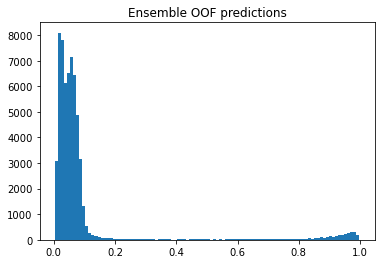

In [7]:
md = x[:,m[0]]
for i,k in enumerate(m[1:]):
    md = w[i]*x[:,k] + (1-w[i])*md
plt.hist(md,bins=100)
plt.title('Ensemble OOF predictions')
plt.show()

In [8]:
df = OOF_CSV[0].copy()
df.pred = md
df.to_csv('ensemble_oof.csv',index=False)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  


# Load SUB Files

In [9]:
SUB = np.sort( [f for f in FILES if 'sub' in f] )
SUB_CSV = [pd.read_csv(PATH+k) for k in SUB]

print('We have %i submission files...'%len(SUB))
print(); print(SUB)

We have 7 submission files...

['eca_nfnetl0_sub_01.csv' 'eff_b0_ns_sub_06.csv' 'eff_b0_sub_05.csv'
 'eff_b3_ns_sub_07.csv' 'eff_b3_ns_w15_sub_02.csv'
 'eff_b3_ns_w9_sub_04.csv' 'eff_v2_s_sub_03.csv']


In [10]:
# VERFIY THAT SUBMISSION FILES MATCH OOF FILES
a = np.array( [ int( x.split('_')[-1].split('.')[0]) for x in SUB ] )
b = np.array( [ int( x.split('_')[-1].split('.')[0]) for x in OOF ] )
if len(a)!=len(b):
    print('ERROR submission files dont match oof files')
else:
    for k in range(len(a)):
        if a[k]!=b[k]: print('ERROR submission files dont match oof files')

In [11]:
y = np.zeros(( len(SUB_CSV[0]),len(SUB) ))
for k in range(len(SUB)):
    y[:,k] = SUB_CSV[k].target.values

# Build SUB Ensemble

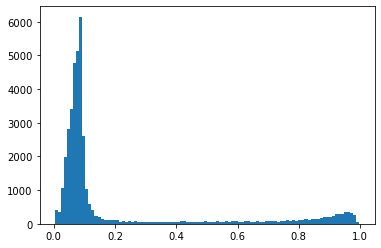

In [12]:
md2 = y[:,m[0]]
for i,k in enumerate(m[1:]):
    md2 = w[i]*y[:,k] + (1-w[i])*md2
plt.hist(md2,bins=100)
plt.show()

In [13]:
df = SUB_CSV[0].copy()
df.target = md2
df.to_csv('ensemble_subv2.csv',index=False)